In [190]:
from glob import glob
import numpy as np
import pandas as pd

### Create the training dataset

In [191]:
# Extract the subjects' label.
path_labels = '../data/risk_golden_truth.txt'
labels = {}
with open(path_labels, 'r') as f:
    for line in f:
        subject, label = line.split()
        labels[subject] = int(label)

In [192]:
def create_dataset():
   # Create the train dataset from the subjects' posts and label.
   txt_path = glob('../data/processed/*')
   rows_data = []
   for path in txt_path:
      with open(path, 'r+') as f:
         # Split the path, get the filename 
         # (which contains the subject) and remove '.txt'
         subject = path.split('\\')[1][:-4] 
         txt = f.read()
         rows_data.append((subject, txt, labels[subject]))

   # Training dataset.
   train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])
   return train_data

In [193]:
train_data = create_dataset()

In [194]:
train_data

,Subject,Text,Label
0,subject1,Vulcan's ultimate landing at max range is so s...,0
1,subject100,I almost only play Marathon/Huge. I enjoy slow...,0
2,subject1006,http://imgur.com/igov5qk http://imgur.com/vHu8...,0
3,subject1008,What are the list of softwares you use for day...,0
4,subject1011,Subscribe and like will help me #128522;\nLoL\...,0
...,...,...,...
2343,subject9980,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2344,subject9981,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2345,subject9986,Checkout r/GoGoJoJo against the qualified immu...,0
2346,subject9990,Only took about 10 tries to post correctly lol...,0


### Preprocess the subjects' posts
Text normalization techniques:
- lowercasing 
- whitespace removal
- URL removal
- tokenization
- stopwords removal
- punctuation removal
- stemming

In [195]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

In [196]:
# Normalize all words to lowercase.
train_data["Text"] = train_data["Text"].str.lower()

In [197]:
def remove_whitespace(text):
   """ Removes all whitespaces from a given text."""
   return " ".join(text.split())

In [198]:
# Remove all whitespaces from texts.
train_data["Text"] = train_data["Text"].apply(remove_whitespace)

In [199]:
def remove_URLs(text):
   "Remove URLs from text using regular expressions."
   url_re = re.compile(r'https?://\S+|www\.\S+')
   return url_re.sub(r'', text)

In [200]:
train_data["Text"][2][:200]

'http://imgur.com/igov5qk http://imgur.com/vhu8cjn this was just a lucky run all around. i got some good crew early and then got good system levels like shields and engines. this let me focus on a weap'

In [201]:
# Remove URLs from texts.
train_data["Text"] = train_data["Text"].apply(remove_URLs)

,Subject,Text,Label
0,subject1,vulcan's ultimate landing at max range is so s...,0
1,subject100,i almost only play marathon/huge. i enjoy slow...,0
2,subject1006,this was just a lucky run all around. i got ...,0
3,subject1008,what are the list of softwares you use for day...,0
4,subject1011,subscribe and like will help me #128522; lol i...,0
...,...,...,...
2343,subject9980,"i've been too lazy to go play recently, warm w...",0
2344,subject9981,[removed] [view poll]( read rule 3. read my fl...,0
2345,subject9986,checkout r/gogojojo against the qualified immu...,0
2346,subject9990,only took about 10 tries to post correctly lol...,0


In [202]:
train_data["Text"][2][:200]

'  this was just a lucky run all around. i got some good crew early and then got good system levels like shields and engines. this let me focus on a weapons system, and someone truly blessed me. triple'

In [203]:
# Extract tokens from texts.
train_data["Text"] = train_data["Text"].apply(lambda x: word_tokenize(x))

,Subject,Text,Label
0,subject1,"[vulcan, 's, ultimate, landing, at, max, range...",0
1,subject100,"[i, almost, only, play, marathon/huge, ., i, e...",0
2,subject1006,"[this, was, just, a, lucky, run, all, around, ...",0
3,subject1008,"[what, are, the, list, of, softwares, you, use...",0
4,subject1011,"[subscribe, and, like, will, help, me, #, 1285...",0
...,...,...,...
2343,subject9980,"[i, 've, been, too, lazy, to, go, play, recent...",0
2344,subject9981,"[[, removed, ], [, view, poll, ], (, read, rul...",0
2345,subject9986,"[checkout, r/gogojojo, against, the, qualified...",0
2346,subject9990,"[only, took, about, 10, tries, to, post, corre...",0


In [204]:
def remove_punctuation(text):
   tokenizer = RegexpTokenizer(r'\w+')
   no_punct = tokenizer.tokenize(" ".join(text))
   return no_punct

In [205]:
# Removes punctuation from texts.
train_data["Text"] = train_data["Text"].apply(remove_punctuation)

In [206]:
en_stopwords = stopwords.words('english')
def remove_stopwords(text):
   """Removes english stopwords."""
   result = []
   for token in text:
      if token not in en_stopwords:
         result.append(token)

   return result

In [207]:
# Removes stopwords from texts.
train_data["Text"] = train_data["Text"].apply(remove_stopwords)

In [208]:
def stemming(text):
   porter = PorterStemmer()
   result = []
   for word in text:
      result.append(porter.stem(word))

   return result

In [209]:
# Apply stemming to words from texts.
train_data["Text"] = train_data["Text"].apply(stemming)

In [210]:
# Save the dataset to a .csv file.
train_data.to_csv('../data/train_dataset.csv')

### Standard ML approaches

In [211]:
import time
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [212]:
# Load the training dataset.
train_data = pd.read_csv('../data/train_dataset.csv')

In [213]:
# Visualize the distribution of class labels.
train_data["Label"].value_counts()

0    2184
1     164
Name: Label, dtype: int64

<AxesSubplot:>

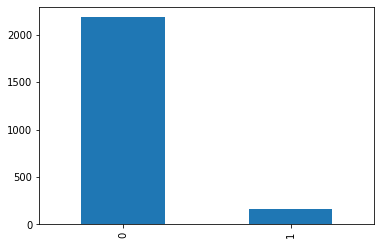

In [214]:
# Visualize the distribution of class labels.
train_data["Label"].value_counts().plot.bar()

### ML experiments
Feature extractors:
- Bag-of-Words
- TF-IDF

Classifiers:
- LinearSVC
- Logistic Regression
- Random Forest
- K-neighbors
- Decision Tree

In [215]:
X = train_data["Text"]
y = train_data["Label"]

# Feature extractors.
feature_extractors = [
CountVectorizer(),
TfidfVectorizer()
# Ignore words that appear in less than 20% of posts (rare words).
CountVectorizer(min_df=0.2),
# Ignore words that appear in more than 80% of posts (frequent words).
CountVectorizer(max_df=0.8),
CountVectorizer(ngram_range=(2, 2)),
CountVectorizer(ngram_range=(3, 3)),
TfidfVectorizer(min_df=0.2),
TfidfVectorizer(max_df=0.8),
TfidfVectorizer(ngram_range=(2, 2)),
TfidfVectorizer(ngram_range=(3, 3))
]

# Classifiers.
classifiers = [ 
LinearSVC(max_iter=100000), 
LogisticRegression(max_iter=100000), 
RandomForestClassifier(), 
KNeighborsClassifier(), 
DecisionTreeClassifier()
]
# Use a stratified 5-fold CV to try to reduce
# the class imbalance in train/validation splits.
cv = StratifiedKFold(n_splits=5)

scoring = {
'accuracy': make_scorer(accuracy_score),
'precision': make_scorer(precision_score),
'recall': make_scorer(recall_score),
'f1_score': make_scorer(f1_score)
}

In [216]:
def start_ML_pipeline():
   for classifier in classifiers:
      for extractor in feature_extractors:
         start_time = time.time()
         pipeline = Pipeline([('extractor', extractor), ('classifier', classifier)])
         scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
         end_time = time.time()
         total_time = round((end_time - start_time)/60, 2)
         
         f1_score = round(np.mean(scores['test_f1_score']), 2)
         precision = round(np.mean(scores['test_precision']), 2)
         recall = round(np.mean(scores['test_recall']), 2)
         acc = round(np.mean(scores['test_accuracy']), 2)

         print("Time: ", total_time, " min")
         print("Experiment: ", str(classifier), "+", str(extractor))
         print("F1 score= ", f1_score, ", 5-fold CV=", scores['test_f1_score'])
         print("Precision= ", precision, ", 5-fold CV=", scores['test_precision'])
         print("Recall= ", recall, ", 5-fold CV=", scores['test_recall'])
         print("Accuracy= ", acc, ", 5-fold CV=", scores['test_accuracy'])
         print("="*100)

In [217]:
start_ML_pipeline()

Time:  1.26  min
Experiment:  LinearSVC(max_iter=100000) + CountVectorizer()
F1 score=  0.85 , 5-fold CV= [0.82191781 0.87878788 0.84848485 0.85294118 0.8358209 ]
Precision=  0.82 , 5-fold CV= [0.75       0.87878788 0.84848485 0.80555556 0.82352941]
Recall=  0.88 , 5-fold CV= [0.90909091 0.87878788 0.84848485 0.90625    0.84848485]
Accuracy=  0.98 , 5-fold CV= [0.97234043 0.98297872 0.9787234  0.97867804 0.97654584]
Time:  1.28  min
Experiment:  LinearSVC(max_iter=100000) + TfidfVectorizer()
F1 score=  0.89 , 5-fold CV= [0.88135593 0.88135593 0.86206897 0.95081967 0.88135593]
Precision=  1.0 , 5-fold CV= [1. 1. 1. 1. 1.]
Recall=  0.81 , 5-fold CV= [0.78787879 0.78787879 0.75757576 0.90625    0.78787879]
Accuracy=  0.99 , 5-fold CV= [0.98510638 0.98510638 0.98297872 0.99360341 0.98507463]


KeyboardInterrupt: 

### Create a dataset with individual posts:
- labeled separately for label=1
- chunks of 20 posts for label=0

In [220]:
def create_dataset_single_posts():
   # Create the train dataset from the subjects' posts and label.
   txt_path = glob('../data/processed/*')
   rows_data = []
   chunks = 20
   for path in txt_path:
      with open(path, 'r+') as f:
         # Split the path, get the filename 
         # (which contains the subject) and remove '.txt'
         subject = path.split('\\')[1][:-4]
         txt = f.read()
         txt = txt.split('\n')
         label = labels[subject]
         i = 0
         chunked_posts = []
         for post in txt:
            # For the posts with label 1, store them individually.
            if label == 1:
               rows_data.append((subject, post, label))
            # For the posts with label 0, form chunks of 20 posts.
            else:
               i +=1
               chunked_posts.append(post)
               if i == chunks:
                  chunked_posts = " ".join(chunked_posts)
                  rows_data.append((subject, chunked_posts, label))
                  chunked_posts = []
                  i = 0

   # Training dataset.
   train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])
   return train_data

In [221]:
train_data_posts = create_dataset_single_posts()
train_data_posts

,Subject,Text,Label
0,subject1,Vulcan's ultimate landing at max range is so s...,0
1,subject1,Idk if it is broken or not but I've noticed th...,0
2,subject1,Nope. I've been playing normally. I play EU th...,0
3,subject1,How can i rebuild it? Ok thanky you. I'll try ...,0
4,subject1,Oh i didn't know that. Let's hope the new syst...,0
...,...,...,...
107558,subject9996,Cool! Thx for cheering me up :) I try my best ...,0
107559,subject9996,beautiful The Last Guest is my idol How can ...,0
107560,subject9996,Oh dm me it's beautiful it's beautiful unfin...,0
107561,subject9996,Sure Nty can I do an very old doge skateboard ...,0


In [222]:
# Visualize the distribution of class labels.
train_data_posts["Label"].value_counts()

1    54840
0    52723
Name: Label, dtype: int64

<AxesSubplot:>

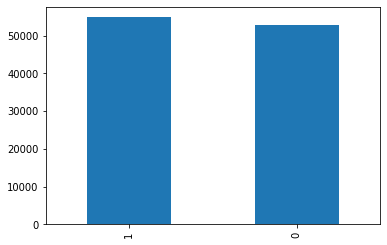

In [223]:
train_data_posts["Label"].value_counts().plot.bar()

In [224]:
# Apply preprocessing on the new dataset.
train_data_posts["Text"] = train_data_posts["Text"].str.lower()

In [225]:
train_data_posts["Text"] = train_data_posts["Text"].apply(remove_whitespace)

In [226]:
train_data_posts["Text"] = train_data_posts["Text"].apply(remove_URLs)

In [227]:
train_data_posts["Text"] = train_data_posts["Text"].apply(lambda x: word_tokenize(x))

In [228]:
train_data_posts["Text"] = train_data_posts["Text"].apply(remove_punctuation)

In [229]:
train_data_posts["Text"] = train_data_posts["Text"].apply(remove_stopwords)

In [230]:
train_data_posts["Text"] = train_data_posts["Text"].apply(stemming)

In [231]:
# Save the dataset to a .csv file.
train_data_posts.to_csv('../data/train_dataset_posts.csv')

In [235]:
# Load the training dataset.
train_data_posts = pd.read_csv('../data/train_dataset_posts.csv')

In [238]:
X = train_data_posts["Text"]
y = train_data_posts["Label"]

# Feature extractors.
feature_extractors = [
CountVectorizer(),
TfidfVectorizer()
# # Ignore words that appear in less than 20% of posts (rare words).
# CountVectorizer(min_df=0.2),
# # Ignore words that appear in more than 80% of posts (frequent words).
# CountVectorizer(max_df=0.8),
# CountVectorizer(ngram_range=(2, 2)),
# CountVectorizer(ngram_range=(3, 3)),
# TfidfVectorizer(min_df=0.2),
# TfidfVectorizer(max_df=0.8),
# TfidfVectorizer(ngram_range=(2, 2)),
# TfidfVectorizer(ngram_range=(3, 3))
]

In [239]:
start_ML_pipeline()

Time:  8.23  min
Experiment:  LinearSVC(max_iter=100000) + CountVectorizer()
F1 score=  0.87 , 5-fold CV= [0.86547417 0.87040569 0.88742577 0.86601027 0.87348429]
Precision=  0.83 , 5-fold CV= [0.82796236 0.82956048 0.8403423  0.81625242 0.83456524]
Recall=  0.92 , 5-fold CV= [0.90654632 0.9154814  0.94009847 0.9222283  0.9162108 ]
Accuracy=  0.86 , 5-fold CV= [0.85631943 0.86101427 0.87839911 0.85449981 0.86468018]
Time:  1.51  min
Experiment:  LinearSVC(max_iter=100000) + TfidfVectorizer()
F1 score=  0.88 , 5-fold CV= [0.87733178 0.86625062 0.89265688 0.87173365 0.87601151]
Precision=  0.86 , 5-fold CV= [0.86523628 0.85333923 0.87193532 0.8462529  0.86404753]
Recall=  0.89 , 5-fold CV= [0.88977024 0.87955872 0.91438731 0.8987965  0.88831145]
Accuracy=  0.87 , 5-fold CV= [0.87314647 0.86152559 0.88788175 0.86514504 0.87179249]
Time:  5.25  min
Experiment:  LogisticRegression(max_iter=100000) + CountVectorizer()
F1 score=  0.91 , 5-fold CV= [0.90574975 0.90533949 0.92152709 0.90106676 